In [1]:
import pandas as pd
from datetime import datetime
df = pd.read_csv('municipality_bus_utilization.csv', index_col=0)  


In [2]:
def func_usage(df, num_manp):
    df2 = df[df['municipality_id'] == num_manp]
    df2.index = pd.to_datetime(df2.index)
    df2["time"] = pd.to_datetime(df2.index)
    df3 = df2.resample('60min', offset=0, label='right')['usage'].max()
    df3 = df3.to_frame()
    df3 = df3.between_time('8:00', '17:00')
    for i in range(len(df3)):
        if(df3.index[i].hour==8 and pd.isna(df3['usage'][i])):
            df3.iloc[i]['usage'] = df3.iloc[i+1]['usage']

    df3['usage'] = df3['usage'].interpolate()
    
    return df3

In [90]:
df2 = df[df['municipality_id'] == 1]
df2.index = pd.to_datetime(df2.index)
df2["time"] = pd.to_datetime(df2.index)
df2

,municipality_id,usage,total_capacity,time
timestamp,,,,
2017-06-04 07:59:42,1,129,397,2017-06-04 07:59:42
2017-06-04 08:25:42,1,138,397,2017-06-04 08:25:42
2017-06-04 08:59:42,1,164,397,2017-06-04 08:59:42
2017-06-04 09:32:46,1,213,397,2017-06-04 09:32:46
2017-06-04 09:59:48,1,245,397,2017-06-04 09:59:48
...,...,...,...,...
2017-08-19 14:30:33,1,410,397,2017-08-19 14:30:33
2017-08-19 15:03:34,1,408,397,2017-08-19 15:03:34
2017-08-19 15:29:33,1,411,397,2017-08-19 15:29:33


In [4]:
df3 = df2.resample('60min', offset=0, label='right')['usage'].max()
df3 = df3.to_frame()
df3 = df3.between_time('8:00', '17:00')
df3[:10]

,usage
timestamp,
2017-06-04 08:00:00,129.0
2017-06-04 09:00:00,164.0
2017-06-04 10:00:00,245.0
2017-06-04 11:00:00,317.0
2017-06-04 12:00:00,341.0
2017-06-04 13:00:00,343.0
2017-06-04 14:00:00,342.0
2017-06-04 15:00:00,341.0
2017-06-04 16:00:00,303.0


---
#### Interpolation

In [5]:
for i in range(len(df3)):
    if(df3.index[i].hour==8 and pd.isna(df3['usage'][i])):
        df3.iloc[i]['usage'] = df3.iloc[i+1]['usage']
        
df3['usage'] = df3['usage'].interpolate()
df3

,usage
timestamp,
2017-06-04 08:00:00,129.0
2017-06-04 09:00:00,164.0
2017-06-04 10:00:00,245.0
2017-06-04 11:00:00,317.0
2017-06-04 12:00:00,341.0
...,...
2017-08-19 13:00:00,406.0
2017-08-19 14:00:00,408.0
2017-08-19 15:00:00,410.0


---

<ipython-input-2-bed93dcc5944>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["time"] = pd.to_datetime(df2.index)


<AxesSubplot:xlabel='timestamp'>

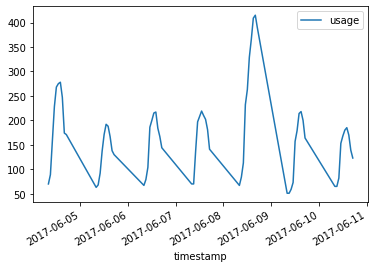

In [6]:
df3 = func_usage(df, 5)
df3[:70].plot()

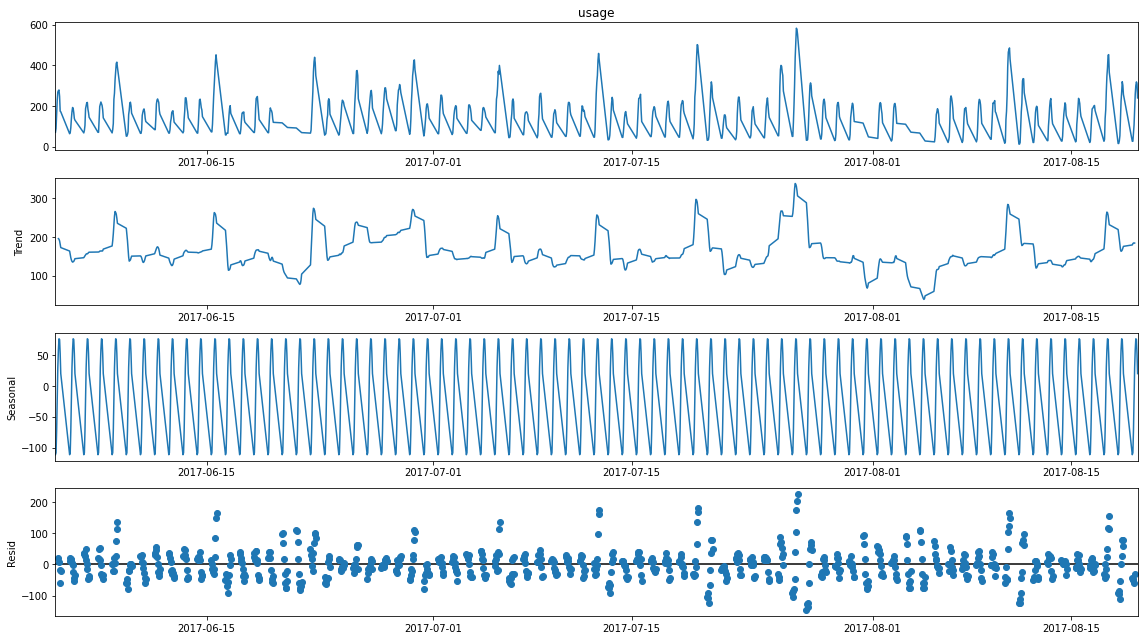

In [79]:
from random import randrange
from pandas import Series
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = 16,9

series = pd.Series(df3['usage'])
result = seasonal_decompose(series, model='additive', period=10)
result.plot()
plt.show()

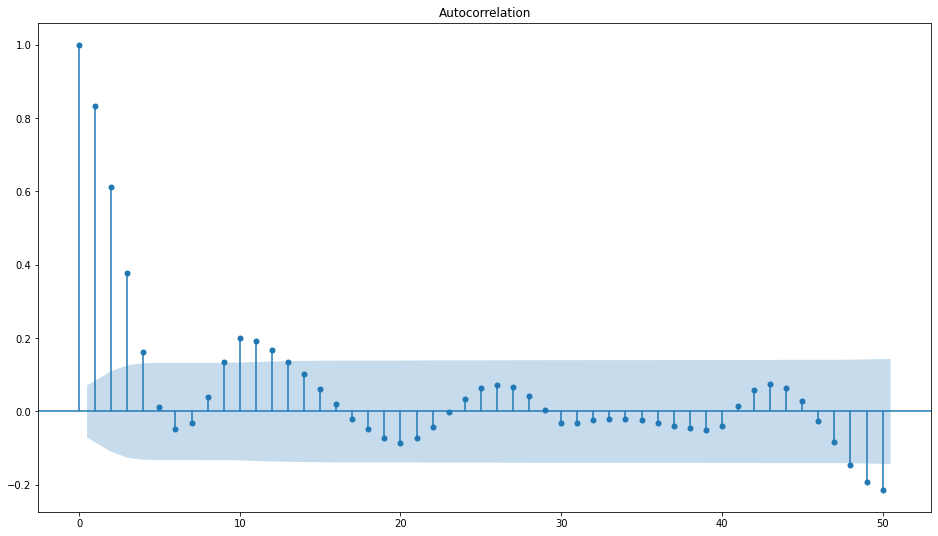

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf((result.resid.dropna()+result.trend.dropna()), lags=50)
plt.show()

Therefore we can say Q = 13

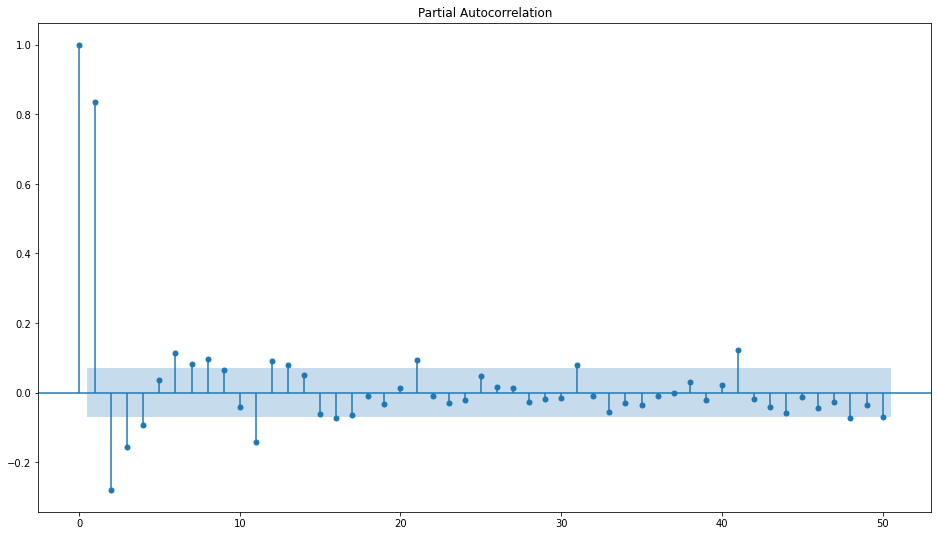

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_pacf((result.resid.dropna()+result.trend.dropna()), lags=50)
plt.show()

Therefore we can say P = 9

Test RMSE: 117.480


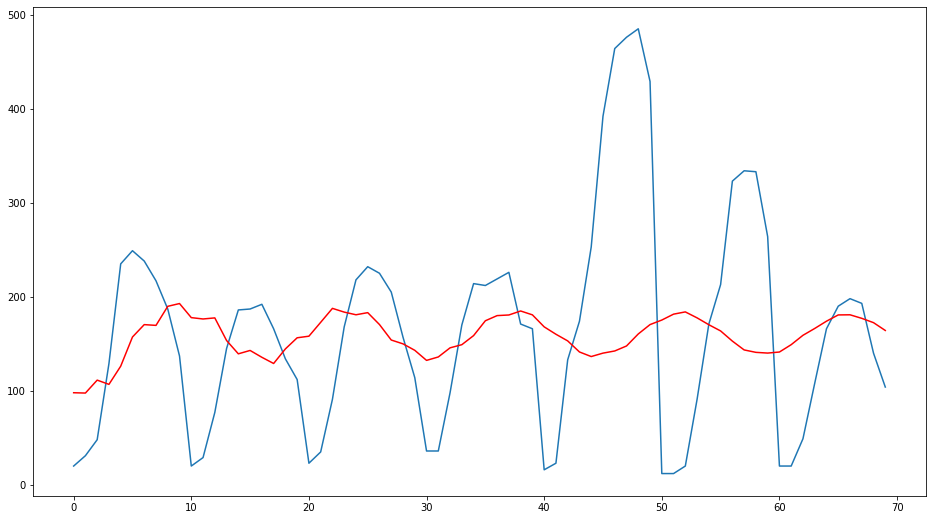

In [82]:
from pandas import read_csv
import numpy as np
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

train = result.resid[:-140].interpolate(method='pad').dropna()+result.trend[:-140].interpolate(method='pad').dropna()
test  = df3['usage'][-140:-70]

history = [x for x in train]
targets = [x for x in test]

predictions = list()

model = ARIMA(history, order=(9,1,13))
res = model.fit()
predictions = res.forecast(steps=70)
    
#print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts

my_prediction = [np.array(predictions)+np.array(result.seasonal[-140:-70])]
rmse1 = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse1)
# plot forecasts against actual outcomes

pyplot.plot(targets)
pyplot.plot(predictions, color='red')
pyplot.show()

In [94]:
train = result.resid[:-70].dropna()+result.trend[:-70].dropna()
test  = result.resid[-70:].dropna()+result.trend[-70:].dropna()

history = [x for x in train]
targets = [x for x in test]

predictions = list()

model = ARIMA(history, order=(9,1,13))
res = model.fit()
predictions = res.forecast(steps=70)

#print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse2 = sqrt(mean_squared_error(test, predictions))

ValueError: Found input variables with inconsistent numbers of samples: [65, 70]